<a href="https://colab.research.google.com/github/ThesanR/TorontoPermitClassification/blob/main/PermitClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#2015 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/fbceeefc-a24d-43d0-8009-a1ec872550d0/download/Cleared%20Permits%202015.zip
!unzip -q "Cleared Permits 2015.zip"
#2016 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/b6f1907e-5a45-43f7-8c3c-56e4edc4f42f/download/Cleared%20Permits%202016.zip
!unzip -q "Cleared Permits 2016.zip"
#2017-2023 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/23de66da-ed1a-434a-a0fa-d85ec55f8f20/download/Cleared%20Building%20Permits%20since%202017.csv
#Active Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/108c2bd1-6945-46f6-af92-02f5658ee7f7/resource/dfce3b7b-4f17-4a9d-9155-5e390a5ffa97/download/building-permits-active-permits.csv

replace clearedpermits2015.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace clearedpermits2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


Classification of Permit applications from the City of Toronto between the years 2000 and 2023.

In [115]:
import pandas as pd
import numpy as np

df2015 = pd.read_csv('clearedpermits2015.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2016 = pd.read_csv('clearedpermits2016.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2017_2023 = pd.read_csv('Cleared Building Permits since 2017.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df = pd.concat([df2015, df2016, df2017_2023], ignore_index=True, sort=False)
df = df.drop(df[(df.POSTAL == "   ") | (df.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD") | (df.STATUS != "Closed")].index)
df = df[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'POSTAL', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
df = df.dropna()

#df['EST_CONST_COST'] = ((df['EST_CONST_COST'].replace(",","", regex=True)).astype(float)).astype(int)
dftemp = ((df['EST_CONST_COST'].replace(",","", regex=True)).astype(float)).astype(int)
df = df.drop('EST_CONST_COST', axis=1)
df = pd.concat([df, dftemp], axis=1)
df = df.drop(df[df.EST_CONST_COST < 100].index)

df = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]
df = df[~df['WORK'].isin((df['WORK'].value_counts())[(df['WORK'].value_counts()) < 1000].index)]
df = df[~df['STRUCTURE_TYPE'].isin((df['STRUCTURE_TYPE'].value_counts())[(df['STRUCTURE_TYPE'].value_counts()) < 500].index)]
df = df[~df['PERMIT_NUM'].isin((df['PERMIT_NUM'].value_counts())[(df['PERMIT_NUM'].value_counts()) > 1].index)]

#print(df.PERMIT_NUM.value_counts(), "\n")
#print(df.POSTAL.value_counts(), "\n")
#print(df.PERMIT_TYPE.value_counts(), "\n")
#print(df.WORK.value_counts(),"\n")
#print(df.STRUCTURE_TYPE.value_counts(), "\n")

pd.set_option('display.max_rows', 25)

perm_num_temp = 2000 + (df['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (df['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
app_year = pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})
#drop under 2010 years

app_datetime = pd.to_datetime(pd.DataFrame({'year' : df['APPLICATION_DATE'].astype(str).str[0:4], 'month' : df['APPLICATION_DATE'].astype(str).str[5:7], 'day' : df['APPLICATION_DATE'].astype(str).str[8:10]}))
issue_datetime = pd.to_datetime(pd.DataFrame({'year' : df['ISSUED_DATE'].astype(str).str[0:4], 'month' : df['ISSUED_DATE'].astype(str).str[5:7], 'day' : df['ISSUED_DATE'].astype(str).str[8:10]}))
app_time_days = pd.to_timedelta((issue_datetime - app_datetime), unit='d')
app_time_days = pd.DataFrame({'TIME_DAYS' : (app_time_days.astype(str).str[0:-5]).astype(int)})
#drop negatives

app_time = app_time_days.astype(str)
app_time = app_time.rename(columns={'TIME_DAYS' : 'PROCESS_TIME'})
app_time['PROCESS_TIME'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 3, 7, 14, 31, 61, 91, 183, 274, 365, 730, float("inf")],
                                labels=['0-3 DAYS', '4-7 DAYS', '1-2 WEEKS', '3-4 WEEKS', '1-2 MONTHS', '2-3 MONTHS', '3-6 MONTHS', '6-9 MONTHS', '9-12 MONTHS', '1-2 YEARS', 'OVER 2 YEARS'],
                                include_lowest=True)

#print(app_time.value_counts(), "\n")

df = df.drop(['PERMIT_NUM', 'APPLICATION_DATE', 'ISSUED_DATE'], axis=1)
df = pd.concat([app_year, df, app_time], axis=1)
df = df.drop(df[df.APPLICATION_YEAR < 2010].index)
df = df.dropna()
#df

In [117]:
from pycaret.classification import *
s = setup(df, target = 'PROCESS_TIME', session_id = 123)

,Description,Value
0,Session id,123
1,Target,PROCESS_TIME
2,Target type,Multiclass
3,Target mapping,"0-3 DAYS: 0, 1-2 MONTHS: 1, 1-2 WEEKS: 2, 1-2 YEARS: 3, 2-3 MONTHS: 4, 3-4 WEEKS: 5, 3-6 MONTHS: 6, 4-7 DAYS: 7, 6-9 MONTHS: 8, 9-12 MONTHS: 9, OVER 2 YEARS: 10"
4,Original data shape,"(71948, 7)"
5,Transformed data shape,"(71948, 45)"
6,Transformed train set shape,"(50363, 45)"
7,Transformed test set shape,"(21585, 45)"
8,Numeric features,2
9,Categorical features,4


In [118]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3506,0.7132,0.3506,0.3577,0.3204,0.1772,0.1846,14.7900
xgboost,Extreme Gradient Boosting,0.3496,0.7119,0.3496,0.3562,0.3257,0.1795,0.1852,9.3280
catboost,CatBoost Classifier,0.3464,0.7118,0.3464,0.3542,0.3218,0.1746,0.1802,90.6210
gbc,Gradient Boosting Classifier,0.3418,0.7063,0.3418,0.3526,0.3064,0.1622,0.1704,83.0310
ada,Ada Boost Classifier,0.3099,0.6307,0.3099,0.2708,0.2644,0.1213,0.1272,3.2740
ridge,Ridge Classifier,0.3084,0.0000,0.3084,0.2753,0.2490,0.1044,0.1134,0.5570
lda,Linear Discriminant Analysis,0.3062,0.6654,0.3062,0.2702,0.2663,0.1203,0.1259,1.3480
rf,Random Forest Classifier,0.3031,0.6600,0.3031,0.2992,0.2992,0.1507,0.1510,10.1100
et,Extra Trees Classifier,0.2909,0.6338,0.2909,0.2884,0.2889,0.1412,0.1413,11.1390
knn,K Neighbors Classifier,0.2837,0.6076,0.2837,0.2880,0.2761,0.1228,0.1238,4.6320


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

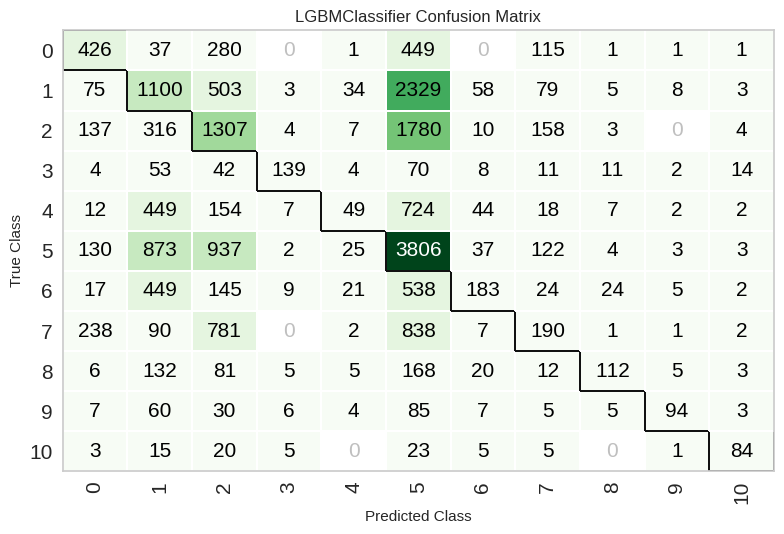

In [119]:
plot_model(best, plot = 'confusion_matrix')

In [120]:
save_model(best, 'PermitTime1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['APPLICATION_YEAR',
                                              'EST_CONST_COST'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missi...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='spl